This is a modified notebook for the project, from the sample code downloaded originally from MedMNIST example at https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb .

In [ ]:
!pip install medmnist

In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import os
from pathlib import Path
import matplotlib.pyplot as plt

# Device setup
# Check for CUDA
if torch.cuda.is_available():
	device = torch.device("cuda")
	print("Using CUDA (GPU)")
	
# Check for MPS (Apple Silicon Macs)
elif torch.backends.mps.is_available():
	device = torch.device("mps")
	print("Using MPS (macOS)")
	
else:
	device = torch.device("cpu")
	print("Using CPU")

# Example usage: Move model and tensors to the selected device

import medmnist
from medmnist import INFO, Evaluator

Using MPS (macOS)


In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [6]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 10
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=224, mmap_mode='r')
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=224, mmap_mode='r')
test_dataset = DataClass(split='test', transform=data_transform, download=download, size=224, mmap_mode='r')

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [ ]:
# import os
# import torch

# os.makedirs('./xai_data_224', exist_ok=True)

# class_counts = {i: 0 for i in range(9)}  # 9 classes in PathMNIST
# max_per_class = 2

# for images, labels in train_loader:
#     for img_tensor, label in zip(images, labels):
#         label = int(label)
#         if class_counts[label] >= max_per_class:
#             continue

#         save_path = f'./xai_data_224/class_{label}_{class_counts[label]}.pt'
#         torch.save(img_tensor, save_path)
#         class_counts[label] += 1

#     if all(c >= max_per_class for c in class_counts.values()):
#         break

# print("Saved 2 tensor samples per class to ./xai_data_224/")

Saved 2 tensor samples per class to ./xai_data_224/


In [7]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST of size 224 (pathmnist_224)
    Number of datapoints: 89996
    Root location: /Users/zhen/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-

In [45]:
x, y = train_dataset[0]

print(x.shape, y.shape)

torch.Size([3, 224, 224]) (1,)


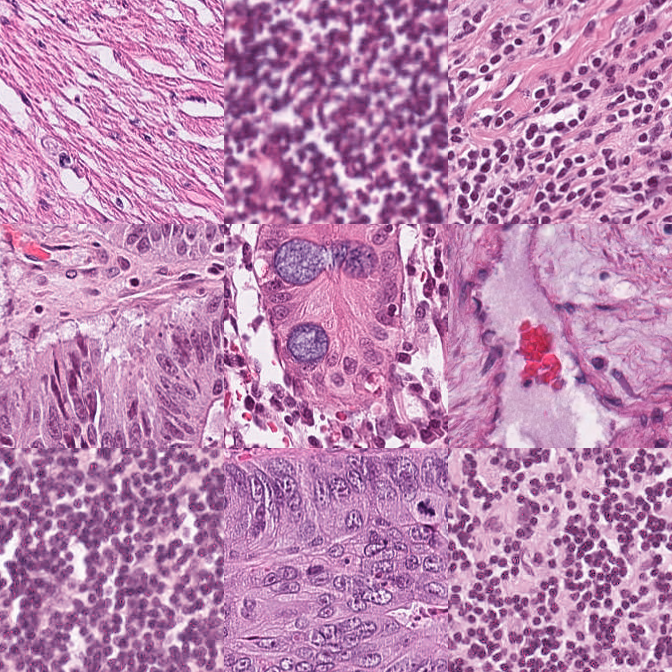

In [46]:
train_dataset.montage(length=3)

## Then we train and evaluate on this 224x224 dataset

In [8]:
from torchvision.models import resnet18

model = resnet18(num_classes=n_classes).to(device)

criterion = nn.CrossEntropyLoss()
	
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)